In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
%run utils.ipynb

## Plan:
* [EDA](#EDA)
* [Clustering](#Clustering)
* [Conclusions](#Conclusions)

In [3]:
df = pd.read_csv('test_data.tsv', sep='\t')

Данные.  
Столбцы:  
- eid - id группы событий (цепочки из показа и клика к нему, если был)
- t - время
- user - id пользователя
- tn - тип события
- geo -  id региона
- cnethash - хеш от сети класса С, к которой принадлежит ip пользователя      
- devtype - тип устройства
- brotype - тип браузера
- bsize - id размера банера (т.е. не сами размеры, а некий идентификатора размера)
- siteid - id канала поставщика трафика
- domhash - хеш от домена
- urlhash - хеш от урла  

В файле клики (tn=1) и показы (tn=0) по одной кампании. Есть гипотеза, что в кампании было накручено много кликов. Необходимо найти какие и объяснить почему.

In [3]:
df.head(3)

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044


In [4]:
df.shape

(48672, 12)

### EDA

Посмотрим на кол-во уникальных значений в каждом столбце

In [14]:
df.nunique()

eid         47157
t           37275
user         4421
tn              2
geo            79
cnethash     3009
devtype         5
brotype         9
bsize           6
siteid          7
domhash      2084
urlhash      7201
dtype: int64

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48672 entries, 0 to 48671
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eid             48672 non-null  int64  
 1   t               48672 non-null  int64  
 2   user            48672 non-null  int64  
 3   tn              48672 non-null  int64  
 4   geo             48672 non-null  int64  
 5   cnethash        48672 non-null  uint64 
 6   devtype         48672 non-null  int64  
 7   brotype         48672 non-null  int64  
 8   bsize           48672 non-null  int64  
 9   siteid          48672 non-null  int64  
 10  domhash         48672 non-null  uint64 
 11  urlhash         48672 non-null  uint64 
 12  time_diff_eid   1515 non-null   float64
 13  time_diff       44251 non-null  float64
 14  norm_time_diff  44186 non-null  float64
dtypes: float64(3), int64(9), uint64(3)
memory usage: 6.9 MB


In [170]:
# построим гистограммы признаков
hist_cols = ['devtype', 'brotype', 'bsize', 'siteid']

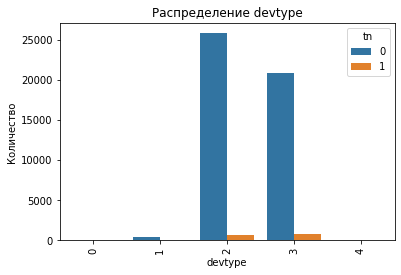

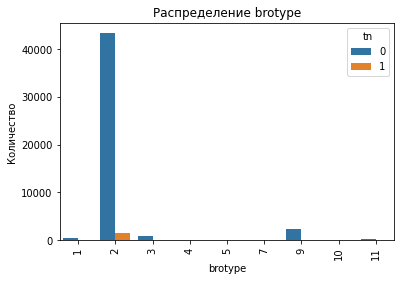

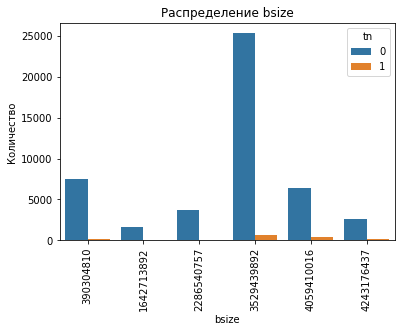

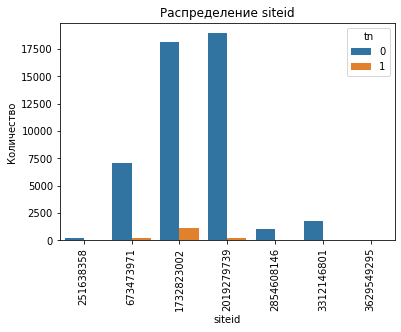

In [188]:
hist_by_target(df, hist_cols, by_target=True)

Теперь разделим данные по типу события

In [4]:
df_tn_1 = df[df['tn'] == 1]
df_tn_0 = df[df['tn'] == 0]

unique_values_tn_1 = df_tn_1.nunique()
unique_values_tn_0 = df_tn_0.nunique()
unique_values_df = pd.DataFrame({'tn=1': unique_values_tn_1, 'tn=0': unique_values_tn_0})

In [5]:
unique_values_df.T

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
tn=1,1547,1539,379,1,62,479,3,7,6,6,207,440
tn=0,47125,35849,4416,1,79,2996,5,9,6,7,2078,7190


Добавим группировку по пользователям

In [6]:
target_users = df[df['tn'] == 1]['user'].unique()
not_target_users = df[df['tn'] == 0]['user'].unique()

In [7]:
df.sort_values(by=['user', 't'], inplace=True)

In [34]:
df['time_diff'] = df.groupby('user')['t'].diff()
min_hash_time_per_user = df.groupby('user')['t'].min()
max_hash_time_per_user = df.groupby('user')['t'].max()
df['norm_time_diff'] = df.apply(lambda row: row['time_diff'] / 
                                (max_hash_time_per_user[row['user']] - min_hash_time_per_user[row['user']]),
                                axis=1
                               )
# кол-во кликов
df['num_clicks'] = df.groupby('user')['tn'].cumsum()
# время от пред. просмотра баннера до клика
df['time_diff_eid'] = df.groupby('eid')['t'].diff()

In [37]:
df[['num_clicks', 'time_diff_eid']].describe()

,num_clicks,time_diff_eid
count,48672.000000,1515.000000
mean,3.374363,16.410561
std,5.516412,58.194809
min,0.000000,0.000000
25%,0.000000,4.000000
50%,1.000000,8.000000
75%,4.000000,13.000000
max,47.000000,1292.000000


In [40]:
# время от просмотра до клика
df.groupby(['devtype','brotype'])['time_diff_eid'].describe()

count       mean        std   min    25%   50%    75%     max
devtype brotype                                                               
0       2          0.0        NaN        NaN   NaN    NaN   NaN    NaN     NaN
1       2         14.0  11.071429   9.294037   3.0   5.25   8.5  11.75    35.0
        3          0.0        NaN        NaN   NaN    NaN   NaN    NaN     NaN
        7          0.0        NaN        NaN   NaN    NaN   NaN    NaN     NaN
        9          0.0        NaN        NaN   NaN    NaN   NaN    NaN     NaN
2       1          1.0   5.000000        NaN   5.0   5.00   5.0   5.00     5.0
        2        651.0  16.337942  47.839791   0.0   4.00   7.0  13.00   789.0
        3          7.0  33.142857  31.125705   8.0  10.50  22.0  43.50    94.0
        5          1.0   3.000000        NaN   3.0   3.00   3.0   3.00     3.0
        9         40.0  10.575000  12.293187   1.0   3.00   6.5  11.00    62.0
        11         1.0   2.000000        NaN   2.0   2.00   2.0   2.00     2.0
3       1         20.0  11.200000  11.057743   2.0   4.75   9.5  13.25    53.0
        2        762.0  16.753281  68.818350   0.0   4.00   8.0  13.00  1292.0
        3         11.0  16.818182  16.460973   2.0   8.50  13.0  17.00    61.0
        4          1.0  13.000000        NaN  13.0  13.00  13.0  13.00    13.0
        9          5.0  40.400000  50.122849   2.0   3.00   7.0  88.00   102.0
        10         0.0        NaN        NaN   NaN    NaN   NaN    NaN     NaN
        11         1.0  16.000000        NaN  16.0  16.00  16.0  16.00    16.0
4       11         0.0        NaN        NaN   NaN    NaN   NaN    NaN     NaN

Есть случаи, когда пользователь сразу кликал на баннер (t_diff=0). Возможно, это накрученные клики.

In [41]:
zero_td_eid = df[df['time_diff_eid']==0].copy()

Сравним признаки для кликнувших и некликнувших пользователей.

In [44]:
group_stats = {'norm_time_diff': 'mean', 
               'num_clicks': 'mean',
               'geo': 'nunique',
               'cnethash': 'nunique',
               'devtype': 'nunique',
               'brotype': 'nunique',
               'bsize': 'nunique',
               'siteid': 'nunique',
               'domhash': 'nunique',
               'urlhash': 'nunique'
}

target_group = df[df['user'].isin(target_users)].groupby('user').agg(group_stats)
not_target_group = df[df['user'].isin(not_target_users)].groupby('user').agg(group_stats)

In [45]:
target_group.describe()

,norm_time_diff,num_clicks,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
count,374.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,0.207805,2.026446,1.258575,2.532982,1.042216,1.084433,2.744063,1.767810,5.406332,11.013193
std,0.323701,2.735727,0.550756,2.175098,0.201348,0.296800,1.431111,0.769056,5.991048,16.207887
min,0.000821,0.030043,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.008658,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
50%,0.040833,0.915888,1.000000,2.000000,1.000000,1.000000,3.000000,2.000000,3.000000,5.000000
75%,0.250000,2.409285,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,7.500000,13.000000
max,1.000000,20.972860,4.000000,21.000000,2.000000,3.000000,6.000000,5.000000,35.000000,130.000000


In [46]:
not_target_group.describe()

,norm_time_diff,num_clicks,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
count,1979.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000
mean,0.513972,0.172786,1.074049,1.336957,1.012228,1.013813,1.396513,1.173913,1.636549,2.458560
std,0.393663,0.980968,0.305772,0.960206,0.109916,0.120547,0.821388,0.459562,2.225847,5.800738
min,0.000821,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.142857,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000
max,1.000000,20.972860,6.000000,21.000000,2.000000,3.000000,6.000000,5.000000,35.000000,130.000000


Заметно, что кликнувшие поль-ли, в среднем, видели больше разных баннеров на разных сайтах. Также они тратили меньше времени на просмотр баннеров.

Возьмем, пользователей, которые кликнули на баннеры, и посмотрим на разницу во времени между просмотром и кликом. 

In [47]:
df_target_users = df[df['user'].isin(target_users)].copy().reset_index(drop=True)

In [48]:
# t_diff - разница по времени от 1-го просмотра (или пред. клика) до нового клика
# act_diff - разница по событиям от 1-го просмотра (или пред. клика) до нового клика

for u in df_target_users['user'].unique():
    user_df = df_target_users[(df_target_users['user']==u)].reset_index(drop=True)

    clicked_banners = user_df[user_df['tn']==1]['bsize'].unique()
    first_occ_idx = [(user_df['bsize'] == i).idxmax() for i in clicked_banners]
    user_df['t_diff'] = 0
    user_df['act_diff'] = 0

    # вычисление разницы по времени (t_diff) и индексу (act_diff)
    for idx in user_df.index:
        banner_size = user_df.at[idx, 'bsize']
        if banner_size in clicked_banners:
            first_occ_index = first_occ_idx[list(clicked_banners).index(banner_size)]
            t_diff = user_df.at[idx, 't'] - user_df.at[first_occ_index, 't']
            act_diff = idx - first_occ_index
            user_df.at[idx, 't_diff'] = t_diff
            user_df.at[idx, 'act_diff'] = act_diff

    for banner in clicked_banners:
        click_idx = user_df[(user_df['tn'] == 1) & (user_df['bsize'] == banner)].index
        user_df.loc[click_idx[1:], ['t_diff', 'act_diff']] = user_df.loc[click_idx, ['t_diff', 'act_diff']].diff()[1:]
    df_target_users.loc[df_target_users['user'] == u, ['t_diff', 'act_diff']] = user_df[['t_diff', 'act_diff']].values

In [49]:
df_target_users[df_target_users['tn']==1].describe().loc[:,'time_diff_eid':]

,time_diff_eid,num_clicks,t_diff,act_diff
count,1502.000000,1547.000000,1.547000e+03,1547.000000
mean,16.180426,6.646412,8.515176e+04,32.138332
std,58.233135,7.231328,1.691991e+05,59.537471
min,0.000000,1.000000,0.000000e+00,0.000000
25%,4.000000,2.000000,9.550000e+01,4.000000
50%,8.000000,4.000000,2.331000e+03,10.000000
75%,13.000000,9.000000,8.758100e+04,32.000000
max,1292.000000,47.000000,1.174988e+06,638.000000


In [323]:
df_target_users[df_target_users['tn']==1].describe().loc[:,'time_diff_eid':]

,time_diff_eid,num_clicks,t_diff,act_diff
count,1502.000000,1547.000000,1.547000e+03,1547.000000
mean,16.180426,6.646412,8.515176e+04,32.138332
std,58.233135,7.231328,1.691991e+05,59.537471
min,0.000000,1.000000,0.000000e+00,0.000000
25%,4.000000,2.000000,9.550000e+01,4.000000
50%,8.000000,4.000000,2.331000e+03,10.000000
75%,13.000000,9.000000,8.758100e+04,32.000000
max,1292.000000,47.000000,1.174988e+06,638.000000


In [52]:
# сгруппируем по баннерам
df_target_users[df_target_users['tn']==1].groupby('bsize')[['time_diff_eid','act_diff']].describe().T

bsize                390304810   1642713892  2286540757   3529439892  \
time_diff_eid count  193.000000   91.000000   45.000000   596.000000   
              mean    18.279793   28.307692   62.800000    11.927852   
              std     29.615847   33.191931  155.689610    48.687166   
              min      0.000000    0.000000    0.000000     0.000000   
              25%      4.000000    7.500000    2.000000     4.000000   
              50%      8.000000   21.000000   11.000000     7.000000   
              75%     15.000000   38.000000   57.000000    12.000000   
              max    194.000000  209.000000  789.000000  1134.000000   
act_diff      count  199.000000   98.000000   64.000000   602.000000   
              mean    41.567839   11.785714    9.906250    33.715947   
              std     70.257637   45.853026   19.768276    55.388905   
              min      0.000000    0.000000    0.000000     0.000000   
              25%      3.000000    1.000000    1.000000     5.000000   
              50%     15.000000    1.000000    2.500000    13.000000   
              75%     50.000000    2.000000   10.000000    34.000000   
              max    532.000000  405.000000  110.000000   515.000000   

bsize                4059410016   4243176437  
time_diff_eid count  404.000000   173.000000  
              mean    12.787129    17.907514  
              std     34.725285   100.336774  
              min      0.000000     1.000000  
              25%      4.000000     5.000000  
              50%      7.000000     8.000000  
              75%     12.000000    13.000000  
              max    557.000000  1292.000000  
act_diff      count  407.000000   177.000000  
              mean    32.798526    33.960452  
              std     68.921914    48.241858  
              min      0.000000     0.000000  
              25%      4.000000     5.000000  
              50%      8.000000    10.000000  
              75%     29.000000    40.000000  
              max    638.000000   238.000000

Сгруппируем по пользователям с большим кол-ом кликов

In [65]:
df_target_users[(df_target_users['tn']==1)&(df_target_users['num_clicks']>10)].groupby('user').agg(group_stats)

,norm_time_diff,num_clicks,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
user,,,,,,,,,,
1636,2.075911e-05,12.0,1,1,1,1,2,1,2,2
3443,1.538358e-05,12.0,1,1,1,1,2,1,3,3
4016,7.521164e-06,22.5,1,2,1,2,5,3,11,12
5999,1.583751e-05,13.5,1,1,1,1,2,2,5,5
6886,7.015122e-06,12.0,1,1,1,1,1,1,1,1
8665,2.368714e-05,11.0,1,1,1,1,1,1,1,1
9471,4.876713e-05,19.5,1,1,1,1,4,2,14,14
15400,7.634285e-06,16.5,1,2,1,1,5,2,5,5
16618,4.725053e-06,21.5,2,2,1,1,2,2,3,6


Посмотрим, есть ли пользователи, которые только кликнули на баннер

In [53]:
users_with_clicks = df[df['tn'] == 1]['user'].unique()
users_with_views = df[df['tn'] == 0]['user'].unique()
users_only_with_clicks = set(users_with_clicks) - set(users_with_views)

In [54]:
df[df['user'].isin(users_only_with_clicks)]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,time_diff,norm_time_diff,time_diff_eid,num_clicks
24497,50926332698,1171551,44362,1,2169085419,2174377318747652376,2,2,1642713892,673473971,13155361562194046496,16378248244971783977,NaN,NaN,NaN,1
32342,23954167736,575407,63449,1,2169085419,10577383406077821108,2,2,4059410016,673473971,8983859320354859553,4145499366623405542,NaN,NaN,NaN,1
34218,335561854284,804289,68635,1,1375834299,4904441003943165890,2,2,390304810,673473971,16425724507308113417,6729340803735548704,NaN,NaN,NaN,1
41115,357663855177,1236729,84316,1,239476928,16050548347730779635,2,2,1642713892,673473971,16526122430178620492,13351223982699276684,NaN,NaN,NaN,1
48465,42055971128,973084,99209,1,239476928,9808897751740002020,2,2,2286540757,673473971,18369807234757086389,16595477858679529831,NaN,NaN,NaN,1


6 пользователей только с одной записью

Посмотрим на пользователей с наибольшим кол-ом кликов.

In [55]:
df_tn_1 = df[df['tn'] == 1]
df_tn_0 = df[df['tn'] == 0]

In [56]:
grouped_df = df_tn_1.groupby(['user', 'bsize', 'siteid']).size()
sorted_df = grouped_df.sort_values(ascending=False)

In [57]:
sorted_df.describe()

count    634.000000
mean       2.440063
std        2.793646
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       30.000000
dtype: float64

In [58]:
sorted_df.head(15)

user   bsize       siteid    
16618  3529439892  3312146801    30
87326  3529439892  1732823002    21
31483  4059410016  1732823002    15
29537  4059410016  1732823002    15
       4243176437  1732823002    14
32449  4059410016  1732823002    14
60464  3529439892  1732823002    14
35721  3529439892  1732823002    13
72225  4059410016  1732823002    13
54098  3529439892  1732823002    12
81949  3529439892  1732823002    12
19764  4243176437  1732823002    12
97629  3529439892  1732823002    12
96619  3529439892  1732823002    11
55221  4059410016  1732823002    11
dtype: int64

Выделяется пользователь 16618. Во время клика на баннер у него менялся cnethash. Возможно, это была накрутка.  
Посмотрим на распределение признаков

In [138]:
clicks_df = df_target_users[df_target_users['tn']==1].copy()
clicks_df.fillna(0, inplace=True)

In [140]:
drop_cols = ['eid', 't', 'user', 'tn', 'norm_time_diff']

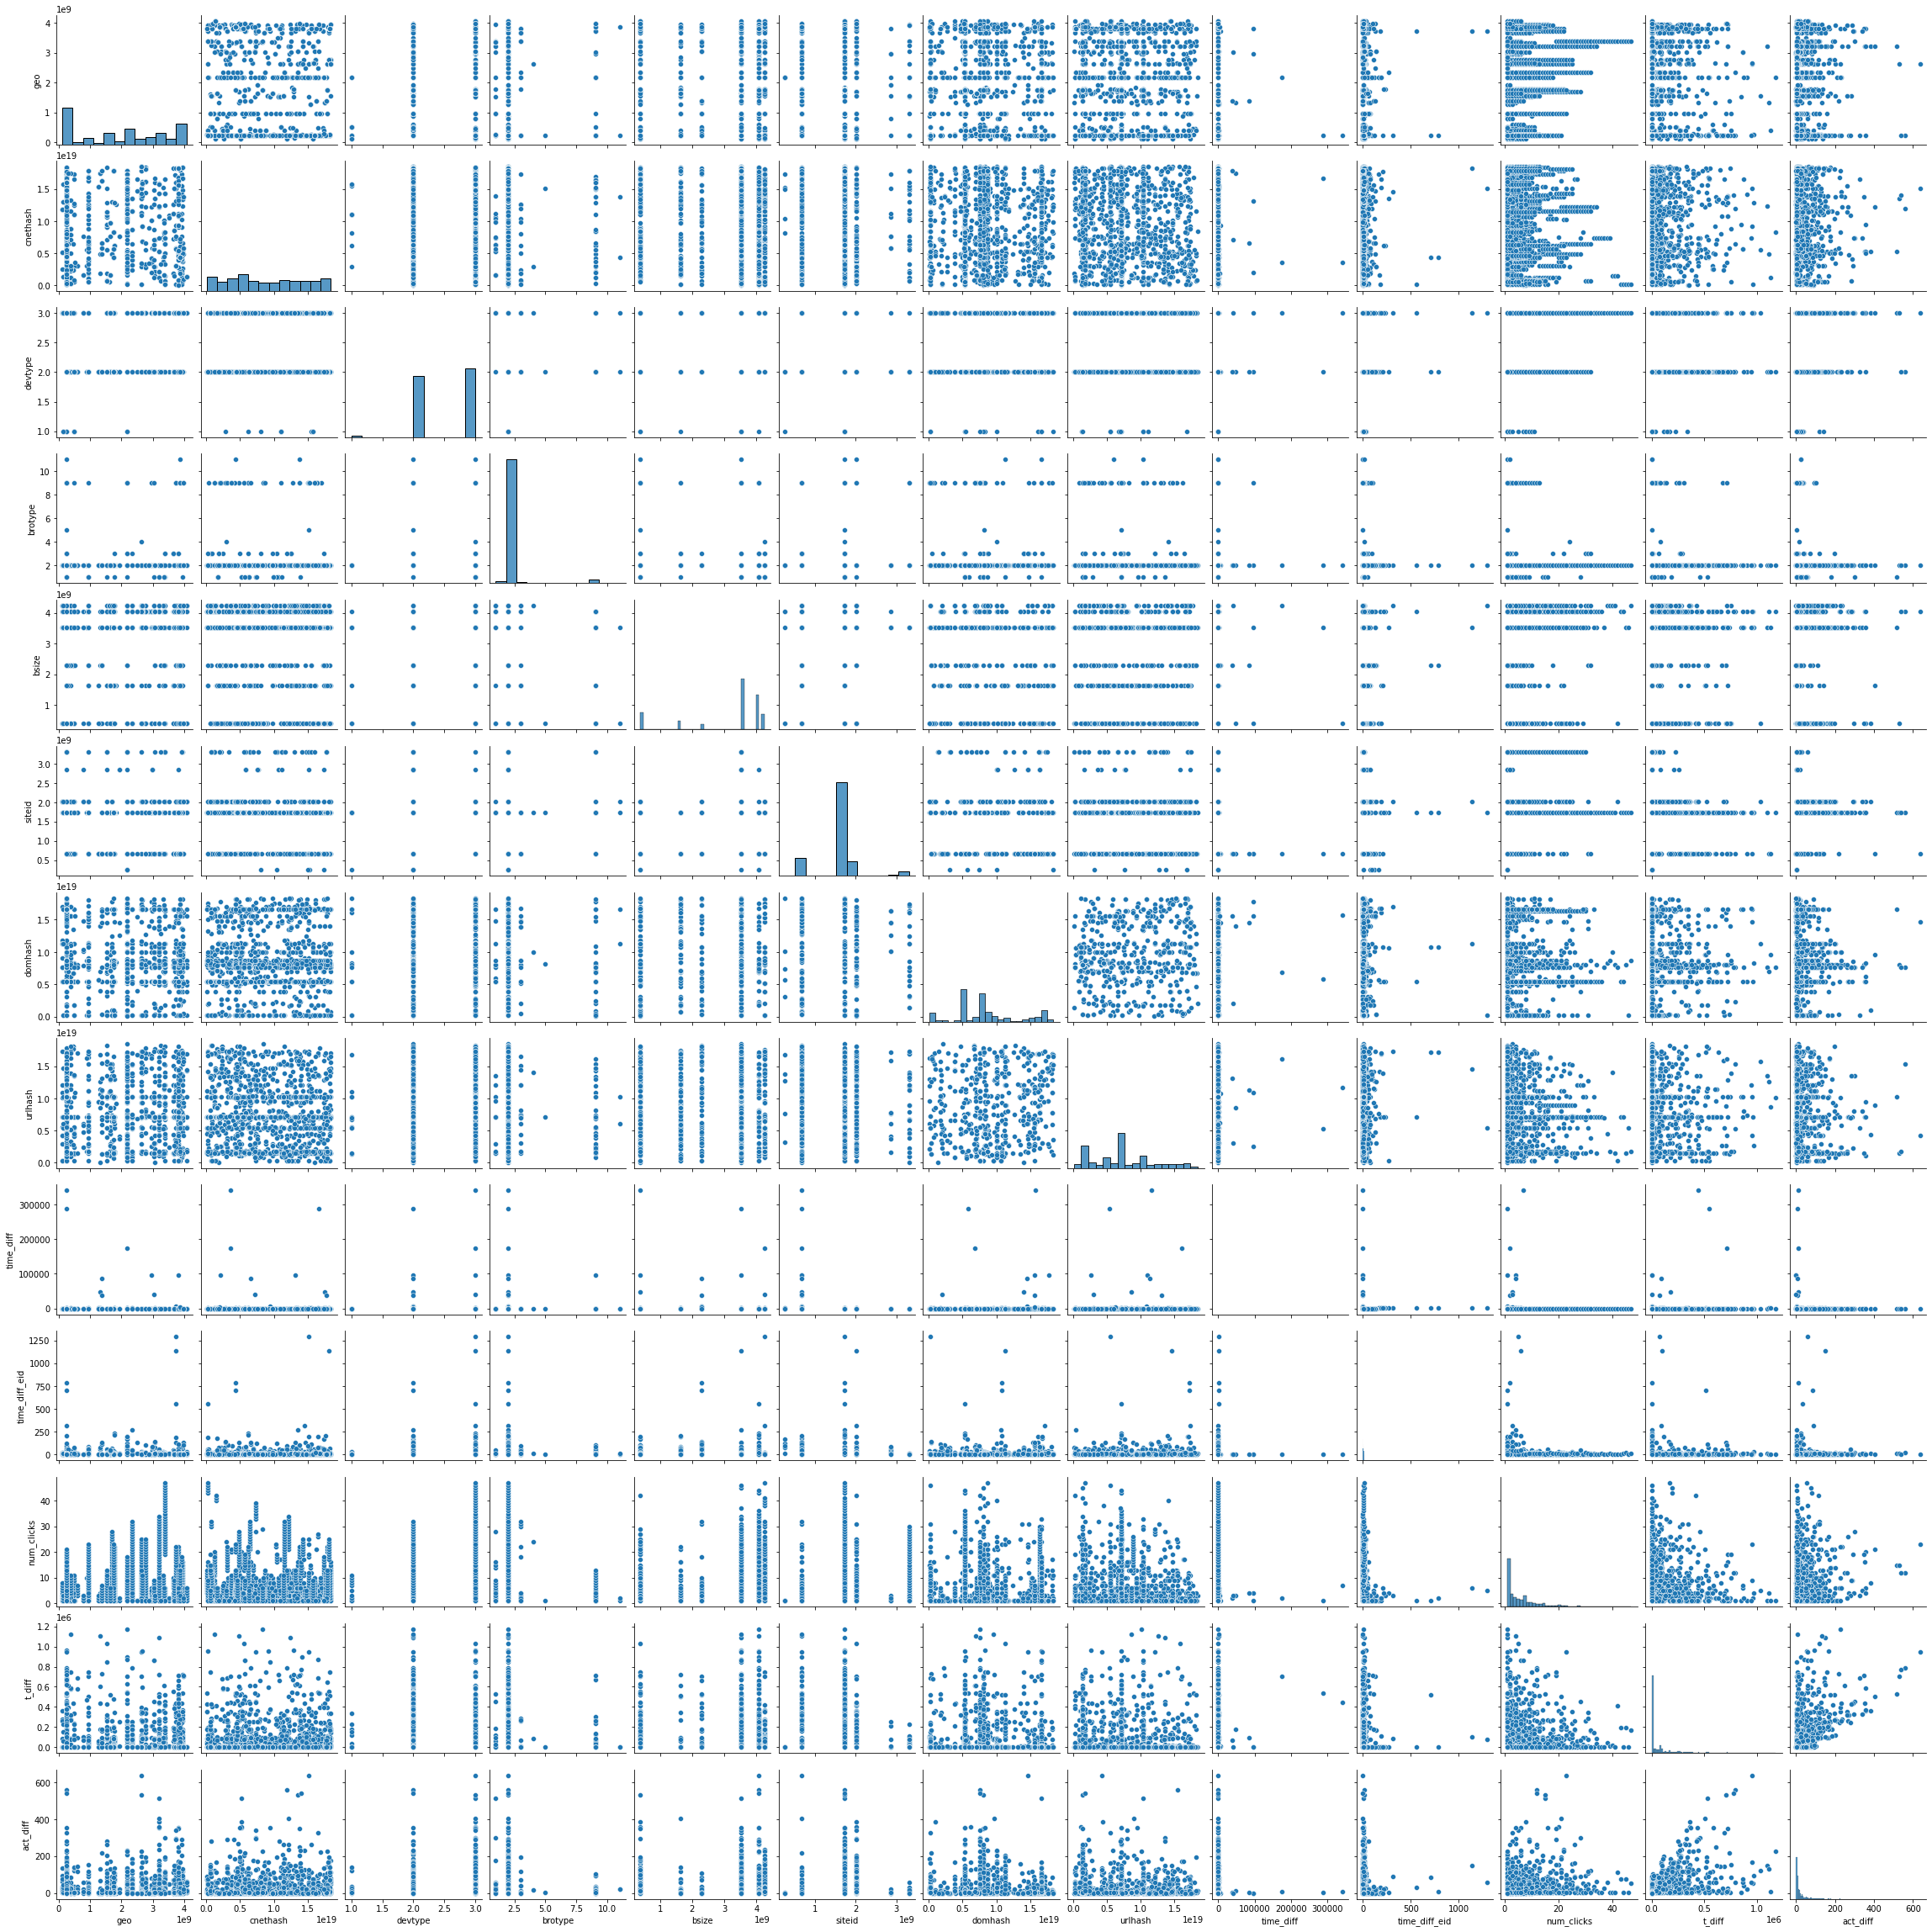

In [141]:
sns.pairplot(clicks_df.drop(columns=drop_cols))
plt.show()

Можно увидеть, что данные делятся на 3 группы по (devtype, bsize, siteid). Возможно, пользователей можно разделить на 3 группы: малоактивные, активные и очень активные (боты).

__Промежуточные итоги__  
Сформируем критерии по которым будем определять накрутку:   

- большое кол-во кликов (num_clicks);
- малое время отклика после просмотра баннера (t_diff);
- большое кол-во действий (act_diff)

In [339]:
# время между просмотром и кликом < 3 (25%)
# 231 клик
clicks_df[clicks_df['time_diff_eid'] < 3].head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,time_diff,norm_time_diff,time_diff_eid,num_clicks,t_diff,act_diff,km3_labels,km2_labels
46,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,2.0,0.000003,2.0,1,2.0,1.0,1,0
274,46798586581,1079068,1971,1,127538460,1366742231653099824,3,2,3529439892,2019279739,7589661441840127586,14712548516689042055,1.0,0.000007,2.0,1,1540.0,65.0,0,0
275,46798626106,1079069,1971,1,127538460,1366742231653099824,3,2,390304810,2019279739,7589661441840127586,14712548516689042055,1.0,0.000007,2.0,2,1540.0,63.0,2,0
579,338813796741,873039,3443,1,2348398181,5123315908805466691,3,2,3529439892,1732823002,16593058030122958800,10314716605508635827,1.0,0.000003,1.0,1,39.0,3.0,0,1
746,356394647048,1218272,3443,1,2348398181,8667362642240693866,3,2,390304810,2019279739,11235656105643165955,12099017473588394907,1.0,0.000003,2.0,11,91313.0,78.0,2,1


In [416]:
cheats_df = clicks_df[clicks_df['time_diff_eid'] < 3].copy()

In [419]:
eids = df[(df['user']==16618)&(df['bsize']==3529439892)&(df['siteid']==3312146801)&(df['tn']==1)]['eid'].unique()
# 30 кликов
additional_records = df_target_users[(df_target_users['user'] == 16618) & 
                        (df_target_users['bsize'] == 3529439892) & 
                        (df_target_users['siteid'] == 3312146801) & 
                        (df_target_users['eid'].isin(eids))&
                        (df_target_users['tn']==1)
                       ]

# Добавляем выбранные записи в cheats_df и удаляем дубликаты
cheats_df = pd.concat([cheats_df, additional_records]).drop_duplicates()

In [421]:
cheats_df.shape

(248, 18)

Также для обнаружения накрученных кликов попробуем сделать кластеризацию.

### Clustering

##### preprocessing  

Сначала сделаем предобработку (стандартизацию) и применим алгоритмы понижения размерности для лучшей интерпретации и ускорении вычислений.

In [422]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import umap

In [423]:
RANDOM_STATE = 42

In [435]:
stay_cols = ['geo', 'cnethash', 'devtype', 'brotype',
             'bsize', 
             'siteid', 
             'domhash', 
             #'urlhash',
             #'norm_time_diff',
             'num_clicks', 't_diff', 'act_diff'
            ]

X = clicks_df[stay_cols]
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

X_scaled = st_scaler.fit_transform(X)
X_scaled = mm_scaler.fit_transform(X_scaled)

In [436]:
pca = PCA().fit(X_scaled)

In [437]:
# 2 компоненты
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_embedding_pca_2 = pca.fit_transform(X_scaled)

In [438]:
pca1 = X_embedding_pca_2[:, 0]
pca2 = X_embedding_pca_2[:, 1]

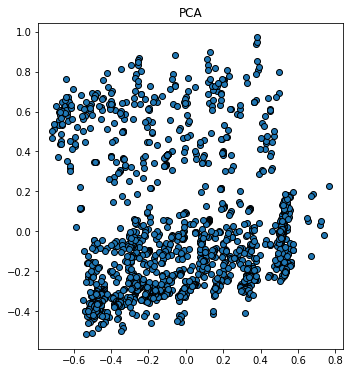

In [439]:
plot2d_components(pca1, pca2, 'PCA')

In [440]:
# umap
umap_model = umap.UMAP(n_components=2)
X_embedding_umap = umap_model.fit_transform(X_scaled)

In [441]:
umap1 = X_embedding_umap[:, 0]
umap2 = X_embedding_umap[:, 1]

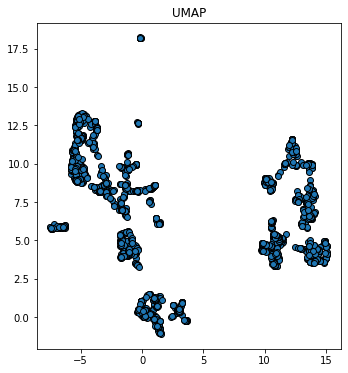

In [442]:
plot2d_components(umap1, umap2, 'UMAP')

In [443]:
# tsne
tsne = TSNE(n_components=2)
X_embedding_tsne = tsne.fit_transform(X_scaled)

In [444]:
tsne1 = X_embedding_tsne[:, 0]
tsne2 = X_embedding_tsne[:, 1]

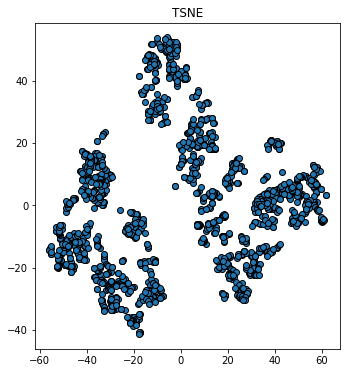

In [445]:
plot2d_components(tsne1, tsne2, 'TSNE')

PCA и TSNE выделяют 2 кластера, UMAP - 3. Остановимяся на 3, предполагая, что две из них люди, а третья - боты.

##### clustering

In [446]:
params_cluster = {
    'KMeans': {
        'random_state': RANDOM_STATE,
    },
#     'SpectralClustering': {
#        # 'n_clusters': 3,
#         'random_state': RANDOM_STATE,
#         'affinity': 'nearest_neighbors',
#         'n_jobs': -1
#     },
#     'AgglomerativeClustering': {
#         'n_clusters': 3,
#     },
}

  0%|          | 0/3 [00:00<?, ?it/s]

2 clusters
----------------------------------------------------------------------


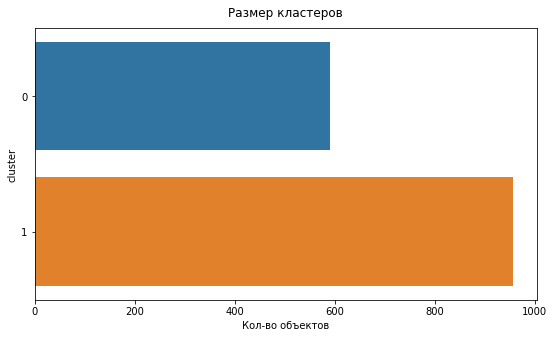

3 clusters
----------------------------------------------------------------------


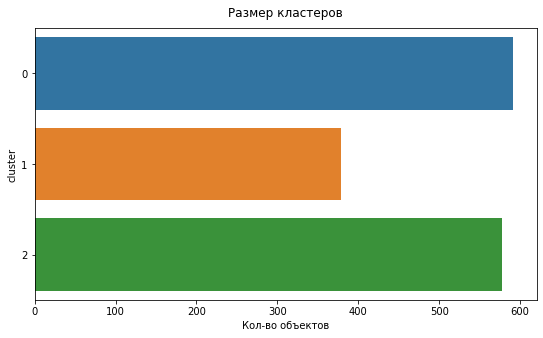

4 clusters
----------------------------------------------------------------------


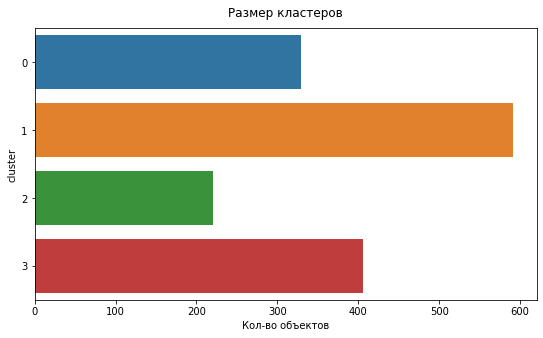

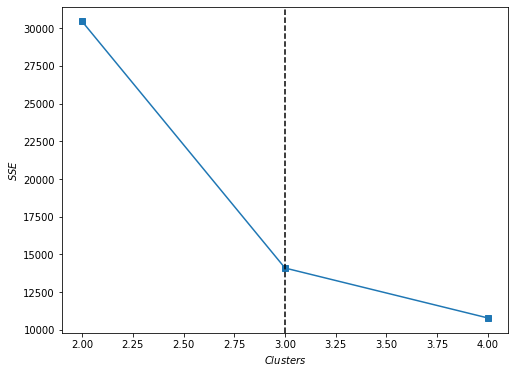

In [447]:
dict_clusters_km = plot_clustering(data=clicks_df[stay_cols],
                                   data_scale=X_scaled,
                                   embedding=X_embedding_umap,
                                   kwargs=params_cluster['KMeans'],
                                   model=KMeans,
                                   type_train='embedding'
                                   )

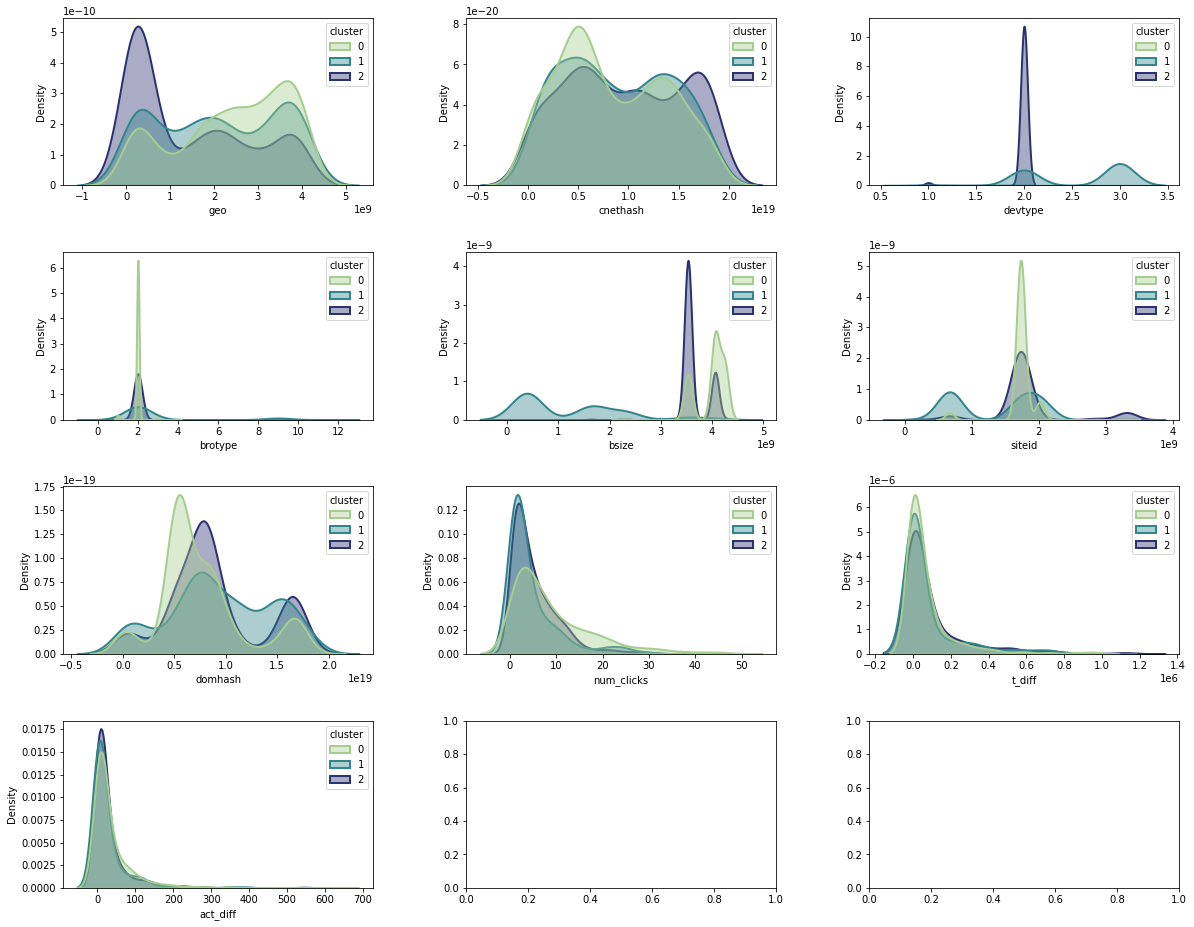

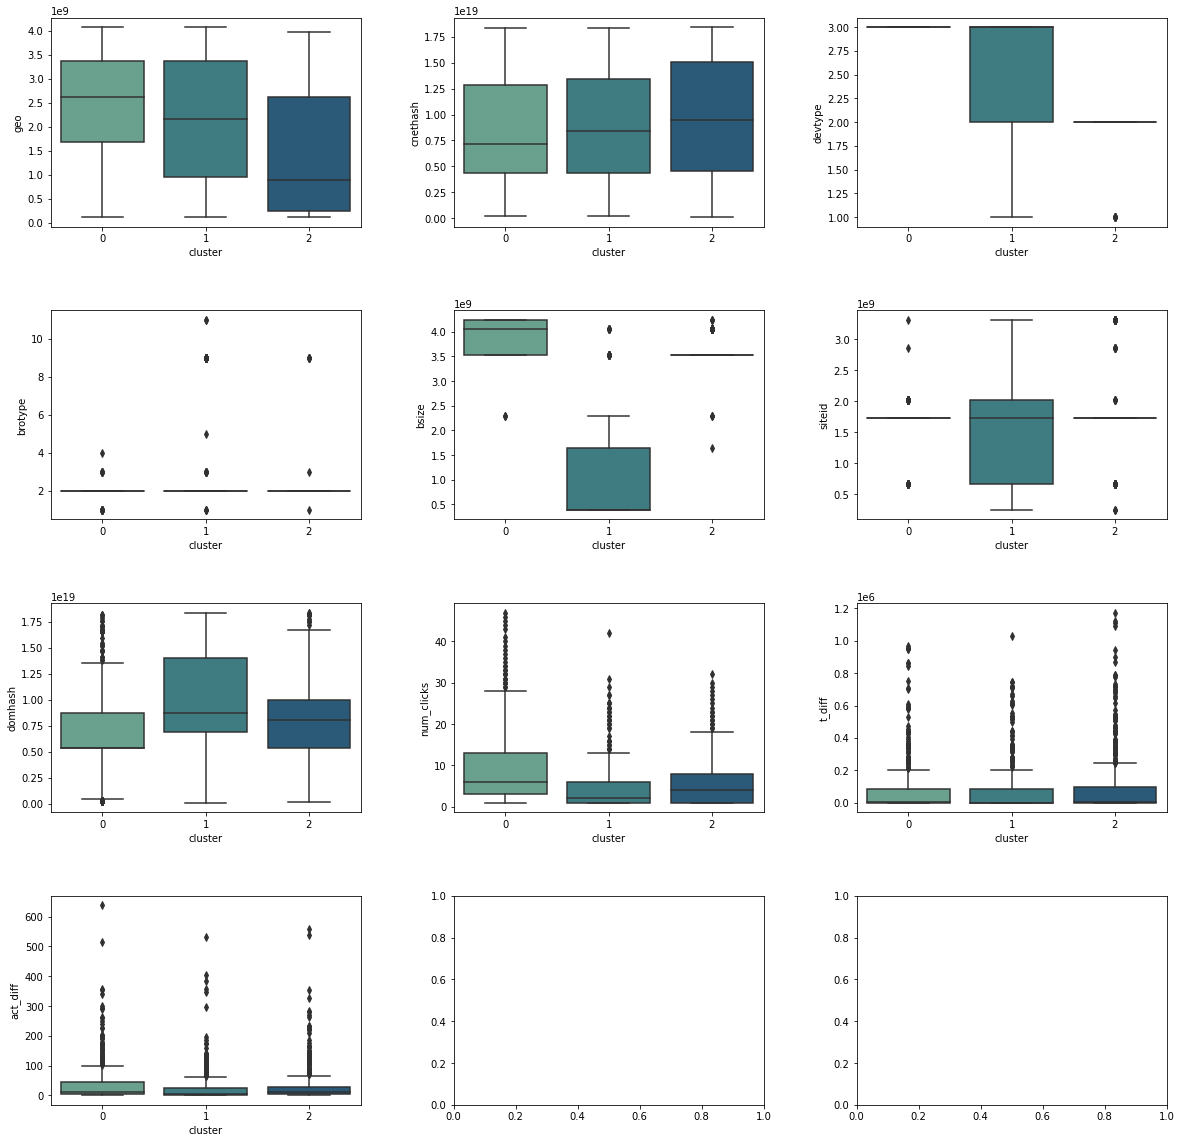

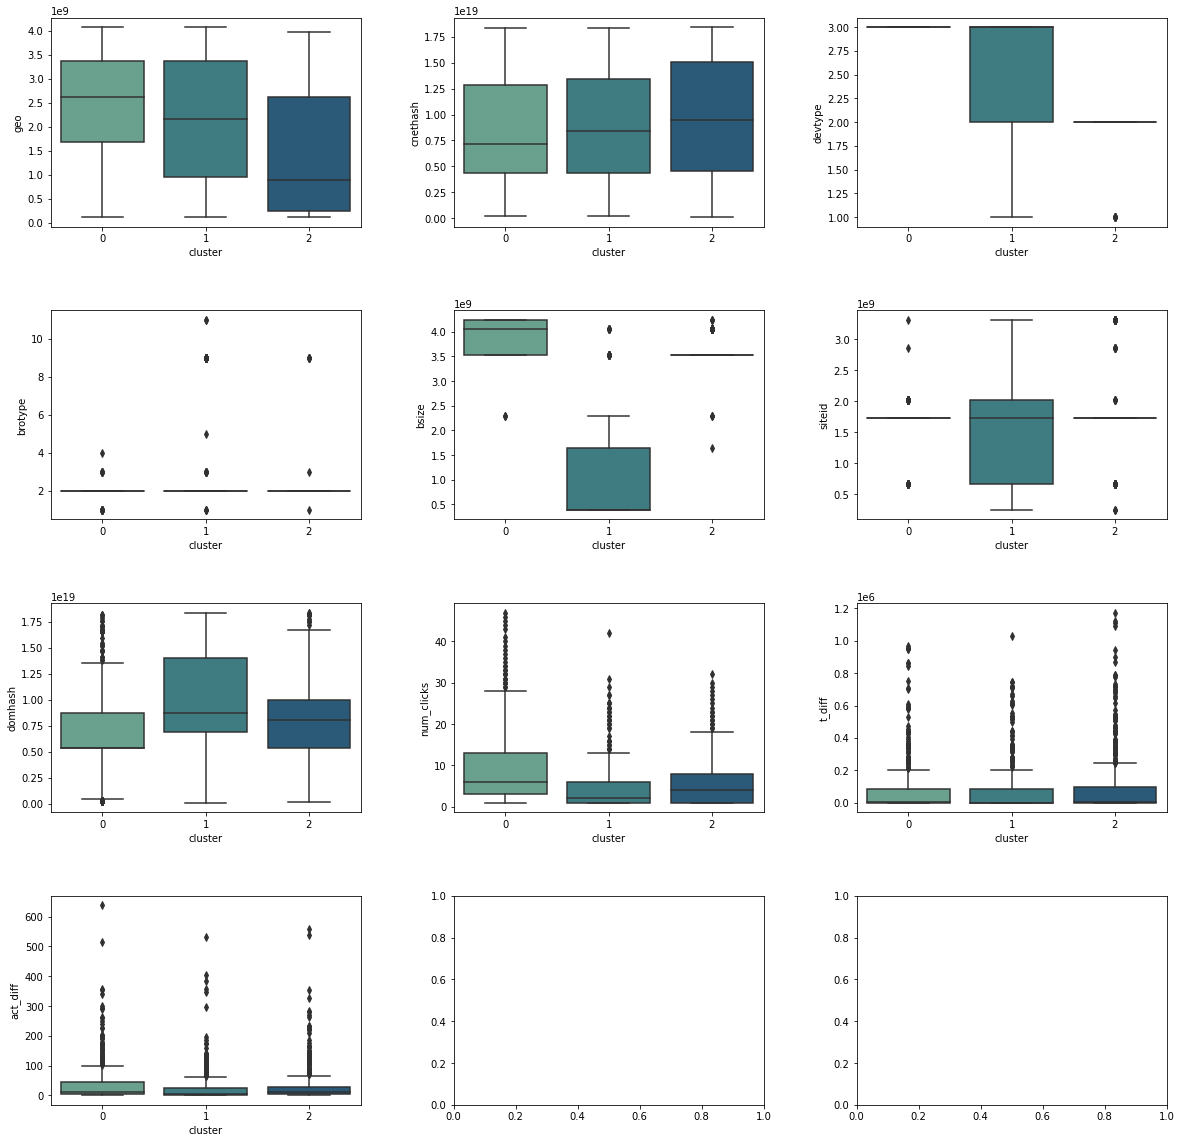

In [448]:
plotting_kde_num(clicks_df[stay_cols], dict_clusters_km[3][0], clicks_df[stay_cols].columns)
plotting_num(clicks_df[stay_cols], dict_clusters_km[3][0], clicks_df[stay_cols].columns)
plotting_num(clicks_df[stay_cols], dict_clusters_km[3][0], clicks_df[stay_cols].columns)

In [449]:
clicks_df['km3_labels'] = dict_clusters_km[3][0]

In [463]:
group_stats = {'t_diff': 'mean', 
               'act_diff': 'mean',
               'num_clicks': 'mean',
               'norm_time_diff': 'mean', 
               'time_diff_eid': 'mean', 
               'geo': 'nunique',
               'cnethash': 'nunique',
               'devtype': 'nunique',
               'brotype': 'nunique',
               'bsize': 'nunique',
               'siteid': 'nunique',
               'domhash': 'nunique',
               'urlhash': 'nunique'
}

clicks_df.groupby('km3_labels').agg(group_stats)

,t_diff,act_diff,num_clicks,norm_time_diff,time_diff_eid,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
km3_labels,,,,,,,,,,,,,
0,72876.165821,36.703892,9.094755,0.008134,15.825719,44,162,1,4,4,5,59,121
1,80614.902375,27.488127,4.804749,0.096111,19.949868,52,210,3,6,5,5,127,251
2,100705.227036,30.516464,5.348354,0.020437,12.805893,45,205,2,4,5,6,76,146


In [453]:
cheats_df

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,time_diff,norm_time_diff,time_diff_eid,num_clicks,t_diff,act_diff
46,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,2.0,0.000003,2.0,1,2.0,1.0
274,46798586581,1079068,1971,1,127538460,1366742231653099824,3,2,3529439892,2019279739,7589661441840127586,14712548516689042055,1.0,0.000007,2.0,1,1540.0,65.0
275,46798626106,1079069,1971,1,127538460,1366742231653099824,3,2,390304810,2019279739,7589661441840127586,14712548516689042055,1.0,0.000007,2.0,2,1540.0,63.0
579,338813796741,873039,3443,1,2348398181,5123315908805466691,3,2,3529439892,1732823002,16593058030122958800,10314716605508635827,1.0,0.000003,1.0,1,39.0,3.0
746,356394647048,1218272,3443,1,2348398181,8667362642240693866,3,2,390304810,2019279739,11235656105643165955,12099017473588394907,1.0,0.000003,2.0,11,91313.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6290,19849644182,471200,16618,1,3371039404,6406880047108242353,2,2,3529439892,3312146801,16333028965850210385,8907186742943232835,15.0,0.000014,15.0,23,2284.0,11.0
6298,19855419555,471311,16618,1,3371039404,6406880047108242353,2,2,3529439892,3312146801,16333028965850210385,8907186742943232835,4.0,0.000004,4.0,24,111.0,8.0
6316,20852387395,509461,16618,1,3371039404,6406880047108242353,2,2,3529439892,3312146801,16333028965850210385,8907186742943232835,3.0,0.000003,3.0,25,38150.0,18.0
6340,21958191416,531449,16618,1,3371039404,6406880047108242353,2,2,3529439892,3312146801,16333028965850210385,12136011708280602978,3.0,0.000003,3.0,28,150.0,6.0


In [457]:
clicks_df.loc[cheats_df.index,:]['km3_labels'].value_counts()

km3_labels
1    88
0    81
2    79
Name: count, dtype: int64

In [460]:
cluster_df = pd.DataFrame(X_embedding_umap, columns=(["col1", "col2"]))

In [461]:
cluster_df['kmeans'] = dict_clusters_km[3][0]

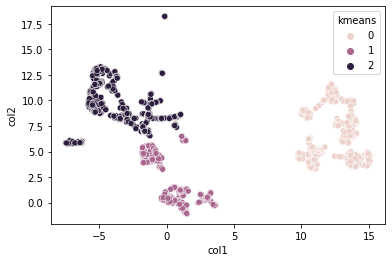

In [462]:
sns.scatterplot(data=cluster_df, x='col1', y='col2', hue='kmeans');

Kmeans неплохо разделил кластеры. Предположительно 0-ой кластер - боты, т.к. происходит меньше времени между просмотром и кликом.  
Однако, клики из предыдущего шага, отмеченные как накрученные, равномерно распределены между 3-мя кластерами. Поэтому требуется дальнейший анализ.

### Conclusions

Было выявлено предположительно накрученных 248 кликов по маленькому времени между просмотром и кликом, а также сменой ip адреса в момент клика. Дальнейшая попытка сделать кластеризацию не дала дополнительной информации. Для этого требуется дальнейший анализ данных, предобработка и перебор моделей кластеризации. 